# scRNA-Seq dataset  [Lee et al. (2023)](https://www.nature.com/articles/s12276-023-01076-z)
in-depth single-cell atlas of in vitro multiculture systems on human primary airway epithelium derived from normal and diseased lungs of 27 individual donors

## Imports

In [1]:
import pandas as pd
import numpy as np
import os, tqdm
import scanpy as sc
from anndata import AnnData
import hdf5plugin
import anndata as ad
from scipy.sparse import csr_matrix
import pandas as pd
from itertools import combinations
from scipy.io import mmwrite
from scipy.io import mmread
import celltypist
from celltypist import models

## Figure Settings

In [2]:
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set font types to ensure text is editable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42   # For PDF export
mpl.rcParams['ps.fonttype'] = 42    # For PS export
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.dpi'] = 600

# Scanpy figure settings
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, 
                     frameon=False, vector_friendly=True, fontsize=12, 
                     figsize=(5,4), color_map=None, format='pdf', facecolor=None, 
                     transparent=False, ipython_format='png')

# scVelo figure settings
scv.set_figure_params(style='scvelo', dpi=80, dpi_save=600, 
                      frameon=False, vector_friendly=True, transparent=True, fontsize=12, 
                      figsize=(5,4), color_map=None, facecolor=None, format='pdf', ipython_format='png')

# Fine-tune Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['figure.subplot.wspace'] = 0.99
plt.rcParams['axes.grid'] = False

import logging
# Suppress INFO messages
logging.getLogger("fontTools").setLevel(logging.WARNING)
plt.set_loglevel('WARNING') 

## Custom colormap

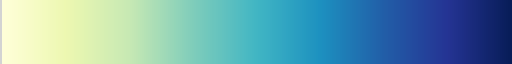

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Define the 'lightgrey' color as an RGBA tuple with values in the range 0-1
lightgrey_rgba = (0.83, 0.83, 0.83, 1.0)  # RGB values for lightgrey with alpha=1.0
# Get the 'YlGnBu' colormap
YlGnBu_cmap = plt.cm.get_cmap('YlGnBu')
# Define the number of steps for interpolation
num_steps = 256
# Define the range for values where lightgrey is used
lightgrey_range = 0.0
# Interpolate between light grey and blue for values from 0 to lightgrey_range
interpolated_colors_below = [lightgrey_rgba] + [YlGnBu_cmap(i) for i in np.linspace(0, 1, int(num_steps * lightgrey_range))]
# Interpolate between light grey and green for values from lightgrey_range to 1
interpolated_colors_above = [YlGnBu_cmap(i) for i in np.linspace(0, 1, int(num_steps * (1 - lightgrey_range)))]
# Combine the two sets of colors
interpolated_colors = interpolated_colors_below + interpolated_colors_above
# Create the custom colormap
cmap = LinearSegmentedColormap.from_list('custom_YlGnBu', interpolated_colors)
# Now you can use this custom colormap in your plots
cmap

## Inspect matrixes AnnData

In [4]:
import numpy as np
from scipy.sparse import issparse

def matrix_summary(adata):
    """
    Prints min, max, and mean for expression matrix, counts layer, raw matrix,
    and scaled layer of an AnnData object.

    Parameters:
        adata: AnnData
    """

    # Helper function to compute min, max, mean
    def summary(matrix, name):
        if issparse(matrix):
            matrix = matrix.toarray()
        flat = matrix.flatten()
        mean_value = flat.mean()
        print(f"{name}: min={flat.min()}, max={flat.max()}, mean={mean_value}")

    # Expression matrix
    summary(adata.X, "Expression matrix (X)")

    # Counts layer
    if 'counts' in adata.layers:
        summary(adata.layers['counts'], "Counts layer matrix (layers['counts'])")
    else:
        print("Counts layer not found in adata.layers.")

    # Raw matrix
    if adata.raw is not None:
        summary(adata.raw.X, "Raw matrix (raw.X)")
    else:
        print("Raw matrix not found in adata.raw.")

    # Scaled layer
    if 'scaled' in adata.layers:
        summary(adata.layers['scaled'], "Scaled layer matrix (layers['scaled'])")
    else:
        print("Scaled layer not found in adata.layers.")

## Load scRNA-Seq data

In [ ]:
# load sparse matrix :
X = mmread("./data/Lee2023/Lee2023invitroAtlas_counts.mtx")

In [ ]:
# create anndata object
adata = ad.AnnData(X=X.transpose().tocsr())

In [11]:
# load cell metadata:
cell_meta = pd.read_csv('./data/Lee2023/Lee2023invitroAtlas_metadata.csv')
cell_meta

,orig.ident,nCount_RNA,nFeature_RNA,status,assignment,percent.mt,nCount_SCT,nFeature_SCT,sample_type,scHCL,...,G2M.Score,Phase,celltype,subclusters,sample_type_celltype,assignment_sample_type_celltype,passage,barcode,UMAP_1,UMAP_2
0,Chromium018,7936,2224,singlet,LRO_020,8.341734,7750,2223,3D,Int.basal.secretory.cell.Airway.Epithelium_Pla...,...,-0.065710,S,Basal,Immune_Deactivated_Basal,3D_Basal,LRO_020_3D_Basal,P6,Chromium018_AAACCCAAGAGTCTGG-1,-1.954364,1.338631
1,Chromium018,11468,4004,singlet,LRO_043,7.725846,8930,3976,3D,Ciliated.cell.Airway.Epithelium_Plasschaert.,...,-0.968837,G1,Ciliated,Immune_Deactivated_Ciliated,3D_Ciliated,LRO_043_3D_Ciliated,P7,Chromium018_AAACCCAAGTATGTAG-1,-12.985492,-0.136841
2,Chromium018,3750,1384,singlet,LRO_029,9.733333,6434,1427,3D,Club.cell.Adult.Lung3.,...,-0.136378,G1,Suprabasal,NaN,3D_Suprabasal,LRO_029_3D_Suprabasal,P5,Chromium018_AAACCCAAGTCAAGCG-1,2.935270,1.394263
3,Chromium018,12876,2981,singlet,LRO_025,1.157192,8821,2864,3D,Secretory.cell.Airway.Epithelium_Plasschaert.,...,-0.302469,G1,Club,NaN,3D_Club,LRO_025_3D_Club,P5,Chromium018_AAACCCACACCGTCGA-1,-1.694712,-5.624819
4,Chromium018,4839,1713,singlet,LRO_025,4.753048,6478,1713,3D,Basal.cell.Adult.Esophagus2.,...,-0.114990,G1,Suprabasal,NaN,3D_Suprabasal,LRO_025_3D_Suprabasal,P5,Chromium018_AAACCCACACGGTGTC-1,0.748673,6.516936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95165,Chromium118,10522,3088,singlet,LRO_018,6.709751,9467,3088,Pneuma_ALI,NaN,...,-0.298420,G1,Suprabasal,NaN,Pneuma_ALI_Suprabasal,LRO_018_Pneuma_ALI_Suprabasal,P9,Pneuma_TTTGTTGCATAAGCAA-1,2.720432,-1.835599
95166,Chromium118,5541,1722,singlet,LRO_098,7.453528,8070,1735,Pneuma_ALI,NaN,...,-0.073970,G1,Club,NaN,Pneuma_ALI_Club,LRO_098_Pneuma_ALI_Club,P10,Pneuma_TTTGTTGGTTCCACGG-1,1.632884,-6.528699
95167,Chromium118,8767,2758,singlet,LRO_029,4.984601,8768,2758,Pneuma_ALI,NaN,...,-0.057161,G1,Club,NaN,Pneuma_ALI_Club,LRO_029_Pneuma_ALI_Club,P7,Pneuma_TTTGTTGTCCGGCAGT-1,0.277049,-6.762817
95168,Chromium118,19386,4594,singlet,LRO_098,5.627773,10168,4050,Pneuma_ALI,NaN,...,-0.244211,G1,Club,NaN,Pneuma_ALI_Club,LRO_098_Pneuma_ALI_Club,P10,Pneuma_TTTGTTGTCGATTTCT-1,-0.834926,-4.907054


In [13]:
# load gene names:
with open ('./data/Lee2023/Lee2023invitroAtlas_gene_names.csv', 'r') as f:
    gene_names = f.read().splitlines()
gene_names

['MIR1302-2HG',
 'FAM138A',
 'OR4F5',
 'AL627309.1',
 'AL627309.3',
 'AL627309.2',
 'AL627309.5',
 'AL627309.4',
 'AP006222.2',
 'AL732372.1',
 'OR4F29',
 'AC114498.1',
 'OR4F16',
 'AL669831.2',
 'LINC01409',
 'FAM87B',
 'LINC01128',
 'LINC00115',
 'FAM41C',
 'AL645608.6',
 'AL645608.2',
 'AL645608.4',
 'LINC02593',
 'SAMD11',
 'NOC2L',
 'KLHL17',
 'PLEKHN1',
 'PERM1',
 'AL645608.7',
 'HES4',
 'ISG15',
 'AL645608.1',
 'AGRN',
 'AL645608.5',
 'AL645608.8',
 'RNF223',
 'C1orf159',
 'AL390719.3',
 'LINC01342',
 'AL390719.2',
 'TTLL10-AS1',
 'TTLL10',
 'TNFRSF18',
 'TNFRSF4',
 'SDF4',
 'B3GALT6',
 'C1QTNF12',
 'AL162741.1',
 'UBE2J2',
 'LINC01786',
 'SCNN1D',
 'ACAP3',
 'PUSL1',
 'INTS11',
 'AL139287.1',
 'CPTP',
 'TAS1R3',
 'DVL1',
 'MXRA8',
 'AURKAIP1',
 'CCNL2',
 'MRPL20-AS1',
 'MRPL20',
 'AL391244.2',
 'ANKRD65',
 'AL391244.1',
 'TMEM88B',
 'LINC01770',
 'VWA1',
 'ATAD3C',
 'ATAD3B',
 'ATAD3A',
 'TMEM240',
 'SSU72',
 'AL645728.1',
 'FNDC10',
 'AL691432.4',
 'AL691432.2',
 'MIB2',
 'MMP

In [14]:
# set anndata observations and index obs by barcodes, var by gene names
adata.obs = cell_meta
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,status,assignment,percent.mt,nCount_SCT,nFeature_SCT,sample_type,scHCL,...,G2M.Score,Phase,celltype,subclusters,sample_type_celltype,assignment_sample_type_celltype,passage,barcode,UMAP_1,UMAP_2
0,Chromium018,7936,2224,singlet,LRO_020,8.341734,7750,2223,3D,Int.basal.secretory.cell.Airway.Epithelium_Pla...,...,-0.065710,S,Basal,Immune_Deactivated_Basal,3D_Basal,LRO_020_3D_Basal,P6,Chromium018_AAACCCAAGAGTCTGG-1,-1.954364,1.338631
1,Chromium018,11468,4004,singlet,LRO_043,7.725846,8930,3976,3D,Ciliated.cell.Airway.Epithelium_Plasschaert.,...,-0.968837,G1,Ciliated,Immune_Deactivated_Ciliated,3D_Ciliated,LRO_043_3D_Ciliated,P7,Chromium018_AAACCCAAGTATGTAG-1,-12.985492,-0.136841
2,Chromium018,3750,1384,singlet,LRO_029,9.733333,6434,1427,3D,Club.cell.Adult.Lung3.,...,-0.136378,G1,Suprabasal,NaN,3D_Suprabasal,LRO_029_3D_Suprabasal,P5,Chromium018_AAACCCAAGTCAAGCG-1,2.935270,1.394263
3,Chromium018,12876,2981,singlet,LRO_025,1.157192,8821,2864,3D,Secretory.cell.Airway.Epithelium_Plasschaert.,...,-0.302469,G1,Club,NaN,3D_Club,LRO_025_3D_Club,P5,Chromium018_AAACCCACACCGTCGA-1,-1.694712,-5.624819
4,Chromium018,4839,1713,singlet,LRO_025,4.753048,6478,1713,3D,Basal.cell.Adult.Esophagus2.,...,-0.114990,G1,Suprabasal,NaN,3D_Suprabasal,LRO_025_3D_Suprabasal,P5,Chromium018_AAACCCACACGGTGTC-1,0.748673,6.516936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95165,Chromium118,10522,3088,singlet,LRO_018,6.709751,9467,3088,Pneuma_ALI,NaN,...,-0.298420,G1,Suprabasal,NaN,Pneuma_ALI_Suprabasal,LRO_018_Pneuma_ALI_Suprabasal,P9,Pneuma_TTTGTTGCATAAGCAA-1,2.720432,-1.835599
95166,Chromium118,5541,1722,singlet,LRO_098,7.453528,8070,1735,Pneuma_ALI,NaN,...,-0.073970,G1,Club,NaN,Pneuma_ALI_Club,LRO_098_Pneuma_ALI_Club,P10,Pneuma_TTTGTTGGTTCCACGG-1,1.632884,-6.528699
95167,Chromium118,8767,2758,singlet,LRO_029,4.984601,8768,2758,Pneuma_ALI,NaN,...,-0.057161,G1,Club,NaN,Pneuma_ALI_Club,LRO_029_Pneuma_ALI_Club,P7,Pneuma_TTTGTTGTCCGGCAGT-1,0.277049,-6.762817
95168,Chromium118,19386,4594,singlet,LRO_098,5.627773,10168,4050,Pneuma_ALI,NaN,...,-0.244211,G1,Club,NaN,Pneuma_ALI_Club,LRO_098_Pneuma_ALI_Club,P10,Pneuma_TTTGTTGTCGATTTCT-1,-0.834926,-4.907054


In [15]:
# set anndata observations and index obs by barcodes, var by gene names
adata.obs = cell_meta
adata.obs.index = adata.obs['barcode']
adata.var.index = gene_names

In [16]:
# load dimensional reduction:
pca = pd.read_csv('./data/Lee2023/Lee2023invitroAtlas_pca.csv')
pca.index = adata.obs.index

In [17]:
# set pca and umap
adata.obsm['X_pca'] = pca.to_numpy()
adata.obsm['X_umap'] = np.vstack((adata.obs['UMAP_1'].to_numpy(), adata.obs['UMAP_2'].to_numpy())).T

... storing 'orig.ident' as categorical
... storing 'status' as categorical
... storing 'assignment' as categorical
... storing 'sample_type' as categorical
... storing 'scHCL' as categorical
... storing 'scHCL_summary' as categorical
... storing 'Sex' as categorical
... storing 'Smoking_status' as categorical
... storing 'Last_smoking' as categorical
... storing 'Smoking_amount' as categorical
... storing 'Comorbidity' as categorical
... storing 'Specimen_Location' as categorical
... storing 'Clinical_diagnosis' as categorical
... storing 'Phase' as categorical
... storing 'celltype' as categorical
... storing 'subclusters' as categorical
... storing 'sample_type_celltype' as categorical
... storing 'assignment_sample_type_celltype' as categorical
... storing 'passage' as categorical


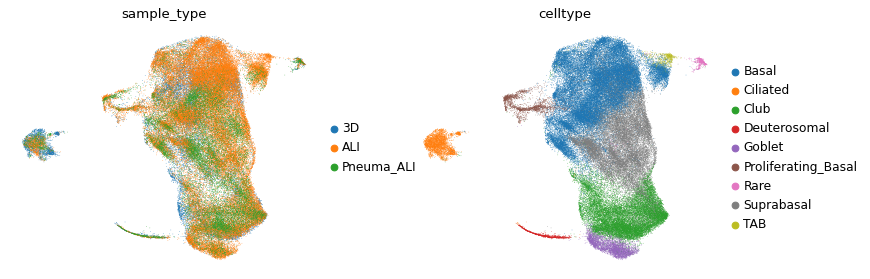

In [18]:
# check the uMAP
sc.pl.umap(adata, color=['sample_type','celltype'],frameon=False)

In [20]:
adata.write_h5ad('./data/Lee2023/Lee2023invitroAtlas.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

## Gene Annotation

We want to be able to merge this data with ours to compare them. 

First we need to make sure genes are annotated the same way in both datasets.

In [17]:
adata=sc.read_h5ad('./data/Lee2023/Lee2023invitroAtlas.h5ad')
adata

AnnData object with n_obs × n_vars = 95170 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'status', 'assignment', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated_snn_res.0.8', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'celltype', 'subclusters', 'sample_type_celltype', 'assignment_sample_type_celltype', 'passage', 'barcode', 'UMAP_1', 'UMAP_2'
    uns: 'celltype_colors', 'sample_type_colors'
    obsm: 'X_pca', 'X_umap'

***NOTICE*** we do not have ENS_IDs for the genes

In [18]:
adata.var

""
MIR1302-2HG
FAM138A
OR4F5
AL627309.1
AL627309.3
...
AC141272.1
AC023491.2
AC007325.1
AC007325.4


This means we will need to map the gene names to their original ENS_ID (*gencode.v32*) and then map those to our names (*gencode.v44*)

In [26]:
# Fxn to parse gencode annotation into dict
def gencode_parser(filepath):
    # Use regular expressions to find gene_id and gene_name regardless of number of columns in input annotation
    import re
    # gene_id_pattern = re.compile(r'gene_id\s+"([^"]+)')
    gene_id_pattern = re.compile(r'gene_id\s+"(ENS[A-Z]+[0-9]+)')
    gene_name_pattern = re.compile(r'gene_name\s+"([^"]+)"')

    with open(filepath, 'r') as f:
        gtf = {
            gene_id_pattern.search(line).group(1) : gene_name_pattern.search(line).group(1)
            for line in f
            if not line.startswith('#')
        }
    return gtf

### *Gencode 32* mapping

In [27]:
# Parse v32 gene annotation and save and inverted dict where:
    # gene_name : ENS_ID
inv_gtf_v32 = {
    v : k
    for k, v in gencode_parser('./data/annotations_aux_files/gencode.v32.annotation.gtf').items()
}

# Store v32 gene name
adata.var['gencode_og_name'] = list(adata.var_names)

# Map v32 gene names to their ENS_IDs
adata.var['gencode_og_id'] = adata.var_names.map(inv_gtf_v32)

del inv_gtf_v32
adata.var

,gencode_og_name,gencode_og_id,gencode_v44_name,summed_genes
gencode_v44_name,,,,
MIR1302-2HG,MIR1302-2HG,ENSG00000243485,MIR1302-2HG,False
FAM138A,FAM138A,ENSG00000237613,FAM138A,False
OR4F5,OR4F5,ENSG00000186092,OR4F5,False
ENSG00000238009,ENSG00000238009,NaN,ENSG00000238009,False
ENSG00000239945,ENSG00000239945,NaN,ENSG00000239945,False
...,...,...,...,...
GPR84-AS1,GPR84-AS1,NaN,GPR84-AS1,True
SPATA13,SPATA13,ENSG00000182957,SPATA13,True
NPIPA9,NPIPA9,ENSG00000233024,NPIPA9,True


### *Gencode v44* mapping

In [21]:
# Parse v44 gene annotation
gtf_v44_annots = gencode_parser('./data/annotations_aux_files/gencode.v44.annotation.gtf')

# We now map the v19 ENS_ID to the v44 ENS_ID's gene name
adata.var['gencode_v44_name'] = adata.var['gencode_og_id'].map(gtf_v44_annots)

del gtf_v44_annots
adata.var

,gencode_og_name,gencode_og_id,gencode_v44_name
MIR1302-2HG,MIR1302-2HG,ENSG00000243485,MIR1302-2HG
FAM138A,FAM138A,ENSG00000237613,FAM138A
OR4F5,OR4F5,ENSG00000186092,OR4F5
AL627309.1,AL627309.1,ENSG00000238009,ENSG00000238009
AL627309.3,AL627309.3,ENSG00000239945,ENSG00000239945
...,...,...,...
AC141272.1,AC141272.1,NaN,NaN
AC023491.2,AC023491.2,NaN,NaN
AC007325.1,AC007325.1,NaN,NaN
AC007325.4,AC007325.4,NaN,NaN


***
NOTICE NaN values can be either for one of two reasons:
    - No v32 ENS_ID to map to v44 ENS_ID
    - A v32 ENS_ID is not included in the v44 annotation, therefore no mapping possible
***

In [22]:
adata.var[adata.var['gencode_v44_name'].isna()]

,gencode_og_name,gencode_og_id,gencode_v44_name
AL109811.2,AL109811.2,ENSG00000271895,NaN
UBXN10-AS1,UBXN10-AS1,ENSG00000225986,NaN
AL356055.1,AL356055.1,ENSG00000270040,NaN
AL031429.2,AL031429.2,ENSG00000269933,NaN
AL049597.2,AL049597.2,ENSG00000261737,NaN
...,...,...,...
AC141272.1,AC141272.1,NaN,NaN
AC023491.2,AC023491.2,NaN,NaN
AC007325.1,AC007325.1,NaN,NaN
AC007325.4,AC007325.4,NaN,NaN


In [23]:
# We will assign the original gene name to those we were unable to map
for var_name in adata.var.index:
    if pd.isna(adata.var.loc[var_name, 'gencode_v44_name']):
        adata.var.loc[var_name, 'gencode_v44_name'] = adata.var.loc[var_name, 'gencode_og_name']

# Display NaN values for v44_names
adata.var[adata.var['gencode_v44_name'].isna()]

,gencode_og_name,gencode_og_id,gencode_v44_name


In [26]:
# We can now make this v44 names the index for the data
adata.var_names = adata.var['gencode_v44_name']

### Handling duplicated gene entries

We now have to make sure there are no duplicates.

**Why could there be duplicates?** 

> Because one gene could have the same gene name with two different ENS_IDs in the original dataset.

In [27]:
# Display duplicated entries
duplicate_var_names = adata.var_names[adata.var_names.duplicated()]
adata.var.loc[adata.var['gencode_v44_name'].isin(duplicate_var_names), :].sort_index()

,gencode_og_name,gencode_og_id,gencode_v44_name
gencode_v44_name,,,
DNAJC9-AS1,AC016394.1,ENSG00000227540,DNAJC9-AS1
DNAJC9-AS1,DNAJC9-AS1,ENSG00000236756,DNAJC9-AS1
ELFN2,ELFN2,ENSG00000166897,ELFN2
ELFN2,FP325335.1,ENSG00000243902,ELFN2
GPR84-AS1,AC079313.1,ENSG00000258086,GPR84-AS1
GPR84-AS1,AC079313.2,ENSG00000258137,GPR84-AS1
LINC00484,LINC00484,ENSG00000235641,LINC00484
LINC00484,AL158071.1,ENSG00000229694,LINC00484
LINC00951,LINC00951,ENSG00000204092,LINC00951


In [28]:
# Filter by duplicated var_names
adata_dup = adata[:, adata.var['gencode_v44_name'].isin(duplicate_var_names)].copy()
adata_dup

AnnData object with n_obs × n_vars = 95170 × 33
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'status', 'assignment', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated_snn_res.0.8', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'celltype', 'subclusters', 'sample_type_celltype', 'assignment_sample_type_celltype', 'passage', 'barcode', 'UMAP_1', 'UMAP_2'
    var: 'gencode_og_name', 'gencode_og_id', 'gencode_v44_name'
    uns: 'celltype_colors', 'sample_type_colors'
    obsm: 'X_pca', 'X_umap'

In [29]:
# We will split the duplicated var_names object into doublets for each unique var_name
duplicates_dict = {}
duplicates_names = list(adata_dup.var_names)
for var_name in duplicates_names:
    duplicates_dict[var_name] = adata_dup[:, var_name]

del duplicates_names
del var_name
duplicates_dict

{'LINC01115': View of AnnData object with n_obs × n_vars = 95170 × 2
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'status', 'assignment', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated_snn_res.0.8', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'celltype', 'subclusters', 'sample_type_celltype', 'assignment_sample_type_celltype', 'passage', 'barcode', 'UMAP_1', 'UMAP_2'
     var: 'gencode_og_name', 'gencode_og_id', 'gencode_v44_name'
     uns: 'celltype_colors', 'sample_type_colors'
     obsm: 'X_pca', 'X_umap',
 'PRICKLE2-AS1': View of AnnData object with n_obs × n_vars = 95170 × 2
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'status', 'assignment', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age'

**NOTICE:** in order to have only one entry for each unique gene, we will sum both their counts value

We will recreate an AnnData object for each duplicated entry with the collpased data and merged metadata

In [30]:
ann_data_dict_sum = {}

for anndata_key, anndata_value in duplicates_dict.items():

    var_name = anndata_value.var_names[:1]
    
    # Sum the expression values for genes for the current AnnData object 
    summed_expression = csr_matrix(anndata_value.X.sum(axis= 1))                     
    
    # Create a new AnnData object to store the summed expression and all merged metadata
    ann_data_dict_sum[anndata_key] = ad.AnnData(
        X = summed_expression,
        obs= anndata_value.obs.copy(),
        var= {
            'gencode_og_id' : ', '.join(list(map(str, set(anndata_value.var.loc[:, 'gencode_og_id'])))),
            'gencode_og_name' : ', '.join(list(map(str, set(anndata_value.var.loc[:, 'gencode_og_name'])))),
            'gencode_v44_name' : ', '.join(list(map(str, set(anndata_value.var.loc[:, 'gencode_v44_name'])))),
            'summed_genes' : True
        },
    )
    # Specify a new name for the collapsed gene axis
    ann_data_dict_sum[anndata_key].var_names = var_name

adata_summed_dups = ad.concat(
    list(ann_data_dict_sum.values()),
    axis= 1,
    join= 'outer',
    merge= 'unique'
)

# Remove all objects we no longer need
del duplicates_dict
del anndata_value
del anndata_key
del summed_expression
del var_name
del ann_data_dict_sum
del adata_dup

adata_summed_dups

AnnData object with n_obs × n_vars = 95170 × 16
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'status', 'assignment', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated_snn_res.0.8', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'celltype', 'subclusters', 'sample_type_celltype', 'assignment_sample_type_celltype', 'passage', 'barcode', 'UMAP_1', 'UMAP_2'
    var: 'gencode_og_id', 'gencode_og_name', 'gencode_v44_name', 'summed_genes'

In [33]:
# Filter out duplicated var_names
adata_unique = adata[:, ~adata.var['gencode_v44_name'].isin(duplicate_var_names)].copy()
adata_unique.var['summed_genes'] = False

# These dimensionality reductions no longer represent the current data
del adata_unique.obsm['X_pca']
del adata_unique.obsm['X_umap']

adata_unique, bool(adata_unique.var_names.duplicated().any())

(AnnData object with n_obs × n_vars = 95170 × 36568
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'status', 'assignment', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated_snn_res.0.8', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'celltype', 'subclusters', 'sample_type_celltype', 'assignment_sample_type_celltype', 'passage', 'barcode', 'UMAP_1', 'UMAP_2'
     var: 'gencode_og_name', 'gencode_og_id', 'gencode_v44_name', 'summed_genes'
     uns: 'celltype_colors', 'sample_type_colors',
 False)

We concat both AnnData objects to have a final one without duplicates and with full metadata

In [ ]:
adata_final = ad.concat(
    [adata_unique, adata_summed_dups],
    axis= 1,
    join= 'outer',
    merge= 'unique'
)
del adata_unique
del adata_summed_dups

adata_final

In [36]:
adata, adata_final

(AnnData object with n_obs × n_vars = 95170 × 36601
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'status', 'assignment', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated_snn_res.0.8', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'celltype', 'subclusters', 'sample_type_celltype', 'assignment_sample_type_celltype', 'passage', 'barcode', 'UMAP_1', 'UMAP_2'
     var: 'gencode_og_name', 'gencode_og_id', 'gencode_v44_name'
     uns: 'celltype_colors', 'sample_type_colors'
     obsm: 'X_pca', 'X_umap',
 AnnData object with n_obs × n_vars = 95170 × 36584
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'status', 'assignment', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smok

In [37]:
# Write to data directory our annotated AnnData
adata_final.write_h5ad(
    './data/Lee2023/Lee2023invitroAtlas_annotated.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

del adata
del adata_final

... storing 'gencode_og_id' as categorical


# Celltypist - Neuroendocrine cells annotataion

In [11]:
adata = sc.read_h5ad('./data/Lee2023/Lee2023invitroAtlas_annotated.h5ad')
adata.raw = adata.copy()
adata.layers['counts'] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 95170 × 36584
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'status', 'assignment', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated_snn_res.0.8', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'celltype', 'subclusters', 'sample_type_celltype', 'assignment_sample_type_celltype', 'passage', 'barcode', 'UMAP_1', 'UMAP_2'
    var: 'gencode_og_name', 'gencode_og_id', 'gencode_v44_name', 'summed_genes'
    layers: 'counts'

In [12]:
matrix_summary(adata)

Expression matrix (X): min=0, max=36617, mean=0.3796851613790149
Counts layer matrix (layers['counts']): min=0, max=36617, mean=0.3796851613790149
Raw matrix (raw.X): min=0, max=36617, mean=0.3796851613790149
Scaled layer not found in adata.layers.


In [21]:
# set pca and umap
# adata.obsm['X_pca'] = pca.to_numpy()
adata.obsm['X_umap'] = np.vstack((adata.obs['UMAP_1'].to_numpy(), adata.obs['UMAP_2'].to_numpy())).T

In [13]:
# Normalize counts per cell.
# Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data matrix.
# Computes X = log (X=1), where X denotes the natural logarithm unless a different base is given.
sc.pp.log1p(adata)

adata.raw = adata.copy()
adata

AnnData object with n_obs × n_vars = 95170 × 36584
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'status', 'assignment', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated_snn_res.0.8', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'celltype', 'subclusters', 'sample_type_celltype', 'assignment_sample_type_celltype', 'passage', 'barcode', 'UMAP_1', 'UMAP_2'
    var: 'gencode_og_name', 'gencode_og_id', 'gencode_v44_name', 'summed_genes'
    uns: 'log1p'
    layers: 'counts'

In [14]:
matrix_summary(adata)

Expression matrix (X): min=0.0, max=8.794102668762207, mean=0.07990922778844833
Counts layer matrix (layers['counts']): min=0, max=36617, mean=0.3796851613790149
Raw matrix (raw.X): min=0.0, max=8.794102668762207, mean=0.07990922778844833
Scaled layer not found in adata.layers.


In [15]:
predictions = celltypist.annotate(adata, model = './data/Celltypist/celltypist_costum_models/Human_Lung_celltype.pkl',   
                                  majority_voting = True,mode = 'best match')

🔬 Input data has 95170 cells and 36584 genes
🔗 Matching reference genes in the model
🧬 2936 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
2026-01-08 00:12:27.427865: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-08 00:12:27.427942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-08 00:12:27.430057: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-08 00:12:29.544378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [16]:
predictions

CellTypist prediction result for 95170 query cells
    predicted_labels: data frame with 3 columns ('predicted_labels', 'over_clustering', 'majority_voting')
    decision_matrix: data frame with 95170 query cells and 22 cell types
    probability_matrix: data frame with 95170 query cells and 22 cell types
    adata: AnnData object referred

In [17]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata(insert_prob = True)
adata.obs['majority_voting']

barcode
Chromium018_AAACCCAAGAGTCTGG-1       Suprabasal
Chromium018_AAACCCAAGTATGTAG-1    Multiciliated
Chromium018_AAACCCAAGTCAAGCG-1            Basal
Chromium018_AAACCCACACCGTCGA-1        Secretory
Chromium018_AAACCCACACGGTGTC-1            Basal
                                      ...      
Pneuma_TTTGTTGCATAAGCAA-1            Suprabasal
Pneuma_TTTGTTGGTTCCACGG-1                Goblet
Pneuma_TTTGTTGTCCGGCAGT-1             Secretory
Pneuma_TTTGTTGTCGATTTCT-1             Secretory
Pneuma_TTTGTTGTCGCGGTAC-1            Suprabasal
Name: majority_voting, Length: 95170, dtype: category
Categories (7, object): ['Basal', 'Goblet', 'Multiciliated', 'PNEC', 'Secretory', 'Suprabasal', 'Tuft']

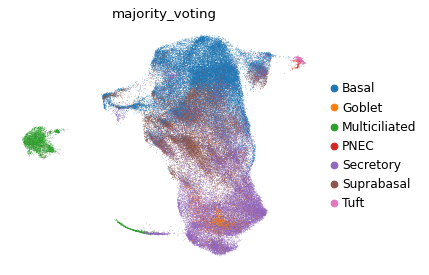

In [22]:
sc.pl.umap(adata, color='majority_voting')

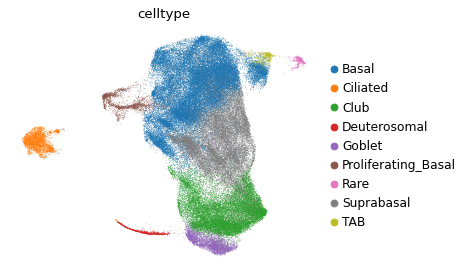

In [23]:
sc.pl.umap(adata, color='celltype')

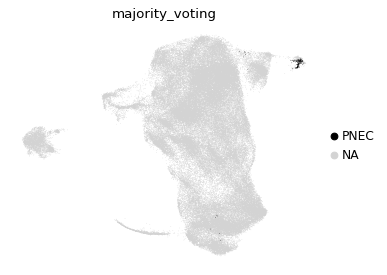

In [24]:
sc.pl.umap(adata, color='majority_voting', groups=['PNEC'], palette=['black'],save='_dAOs-ALI_celltypist_Neuroendocrine')

In [25]:
adata.write_h5ad('./data/Lee2023/Lee2023invitroAtlas_processed.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)